# 가스공급량과 기온 데이터 불러오기(2013-2018년)

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('2013-2018년_가스공급량과_기온2.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,연월일,시간,구분,공급량,year,month,day,weekday,기온
0,0,0,2013-01-01,1,0,2497.129,2013,1,1,1,-6.4
1,1,1,2013-01-01,1,1,2169.093,2013,1,1,1,-6.4
2,2,2,2013-01-01,1,2,226.178,2013,1,1,1,-6.4
3,3,3,2013-01-01,1,3,1434.516,2013,1,1,1,-6.4
4,4,4,2013-01-01,1,4,3272.837,2013,1,1,1,-6.4


### 상관계수 확인

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import platform
from matplotlib import font_manager, rc

In [7]:
path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic')
else:
    print("Unknown System")

C:\Users\kbjoo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kbjoo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

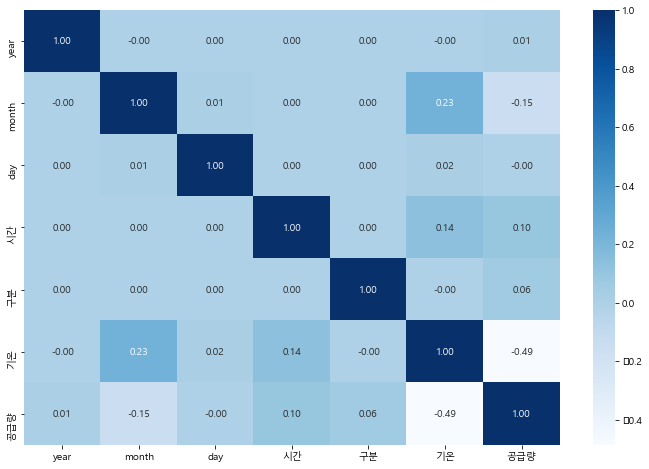

In [8]:
plt.figure(figsize=(12,8))
sns.heatmap(df[['year','month', 'day', '시간', '구분', '기온', '공급량']].corr(), cmap='Blues', annot=True, fmt='.2f')

# XGB회귀 모델 기온 예측 테스트(2013-2018년)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
col = ['year', 'month', 'day', '시간', '구분']
X = df[col]
y = df['기온']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((276066, 5), (92022, 5), (276066,), (92022,))

In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score

In [13]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
kfold = KFold(shuffle=True, random_state=0)
score1 = cross_val_score(xgb, X_train, y_train, cv=kfold).mean()
score2 = cross_val_score(xgb, X_test, y_test, cv=kfold).mean()

In [14]:
print(f"훈련 셋 결정계수 = {score1}")
print(f"테스트 셋 결정계수 = {score2}")

훈련 셋 결정계수 = 0.952556073390334
테스트 셋 결정계수 = 0.9510027405068847


# 기온 예측하기(2019년)

### 2019년 데이터 불러오기

In [15]:
total = pd.read_csv('data/test.csv')
total.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [16]:
total[['year', 'month', 'day', '시간', '구분']] = total['일자|시간|구분'].str.split(r'-| ').tolist()
total.head()

,일자|시간|구분,year,month,day,시간,구분
0,2019-01-01 01 A,2019,01,01,01,A
1,2019-01-01 02 A,2019,01,01,02,A
2,2019-01-01 03 A,2019,01,01,03,A
3,2019-01-01 04 A,2019,01,01,04,A
4,2019-01-01 05 A,2019,01,01,05,A


In [17]:
# 구분 열을 숫자로 바꾸기
d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)
total.head()

,일자|시간|구분,year,month,day,시간,구분
0,2019-01-01 01 A,2019,01,01,01,0
1,2019-01-01 02 A,2019,01,01,02,0
2,2019-01-01 03 A,2019,01,01,03,0
3,2019-01-01 04 A,2019,01,01,04,0
4,2019-01-01 05 A,2019,01,01,05,0


In [18]:
# 2019년 입력 값
col = ['year', 'month', 'day', '시간', '구분']
temp_X = total[col]

### 2019년 기온 예측

In [19]:
temp_pred = xgb.predict(temp_X)
temp_pred

array([-1.7781516, -1.5786556, -2.1287098, ..., 14.15022  , 12.308372 ,
       10.832612 ], dtype=float32)

### 2019년 데이터(total)에 기온값 추가

In [20]:
total['기온'] = temp_pred
total.head()

,일자|시간|구분,year,month,day,시간,구분,기온
0,2019-01-01 01 A,2019,01,01,01,0,-1.778152
1,2019-01-01 02 A,2019,01,01,02,0,-1.578656
2,2019-01-01 03 A,2019,01,01,03,0,-2.128710
3,2019-01-01 04 A,2019,01,01,04,0,-2.408898
4,2019-01-01 05 A,2019,01,01,05,0,-3.094823


# XGB회귀 모델 가스공급량 훈련(2013-2018)

### 기온 포함해서 훈련(2013-2018)

In [21]:
# 훈련 특성(기온 포함)
col = ['year', 'month', 'day', '시간', '구분', '기온']
X = df[col]
y = df['공급량']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((276066, 6), (92022, 6), (276066,), (92022,))

In [23]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
kfold = KFold(shuffle=True, random_state=0)
score1 = cross_val_score(xgb, X_train, y_train, cv=kfold).mean()
score2 = cross_val_score(xgb, X_test, y_test, cv=kfold).mean()

In [24]:
print(f"훈련 셋 결정계수 = {score1}")
print(f"테스트 셋 결정계수 = {score2}")

훈련 셋 결정계수 = 0.9774699424386253
테스트 셋 결정계수 = 0.9765810451865857


## XGB회귀 모델로 가스 공급량 예측(2019년 예측 기온 데이터 포함)

### 기온 포함해서 예측(2019년)

In [25]:
# 2019년 가스공급량 예측(XGB)
col = ['year', 'month', 'day', '시간', '구분', '기온']
final_X = total[col]
gas_pred = xgb.predict(final_X)
gas_pred[:11]

array([2025.7692, 1762.723 , 1677.5206, 1705.6946, 1849.0098, 1876.1938,
       1999.3397, 2170.0798, 2610.8523, 2436.7844, 2380.691 ],
      dtype=float32)

In [26]:
sub = pd.read_csv('data/sample_submission.csv')
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [27]:
sub['공급량'] = gas_pred
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,2025.769165
1,2019-01-01 02 A,1762.723022
2,2019-01-01 03 A,1677.520630
3,2019-01-01 04 A,1705.694580
4,2019-01-01 05 A,1849.009766


In [28]:
sub.loc[sub['공급량']< 0, '공급량'] = 0
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,2025.769165
1,2019-01-01 02 A,1762.723022
2,2019-01-01 03 A,1677.520630
3,2019-01-01 04 A,1705.694580
4,2019-01-01 05 A,1849.009766


### 파일 출력

In [29]:
sub.to_csv("sub01.csv", index=False)

In [30]:
# 데이콘 제출 점수 : 0.2408256567

In [34]:
def evaluation_index(model, x, y):
    y = y.reset_index()
    # 예측값
    pred = model.predict(x)
    # MSE
    mse = ( (y['공급량'] - pred) ** 2 ).sum() / len(pred)
        
    # RMSE
    rmse = mse ** (1/2)
    
    # MAE
    mae = ( abs( y['공급량'] - pred ) ).sum() / len(pred)
    
    # R2
    y_mean = y['공급량'].mean()
    upper = ( (y['공급량'] - pred) ** 2 ).sum()
    lower = ( (y['공급량'] - y_mean) ** 2 ).sum()
    fraction = upper / lower
    r2 = 1 - fraction
    
    #NMAE(Normalized Mean Absolute Error)-정규화 평균 절대 오차 척도
    nmae = ( abs( y['공급량'] - pred ) / y['공급량'] ).sum() / len(pred)
    
    # 평가지표 출력
    print(f"R2 = {r2}")
    print(f"MSE = {mse}")
    print(f"RMSE = {rmse}")
    print(f"MAE = {mae}")
    print(f"NMAE = {nmae}")

In [35]:
evaluation_index(xgb, X_train, y_train)

R2 = 0.9784187042240625
MSE = 18536.08405984618
RMSE = 136.14728811050986
MAE = 86.62458362860205
NMAE = 0.4783786817265499


In [36]:
evaluation_index(xgb, X_test, y_test)

R2 = 0.9776812066465431
MSE = 19242.955226114344
RMSE = 138.7189793291255
MAE = 88.23247561642505
NMAE = 0.4880192582377143
